## Part 3

In [1]:
from datetime import datetime
import numpy as np
import torch
import torchvision
import random
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
device

device(type='cuda')

### reference
https://www.kaggle.com/code/leifuer/intro-to-pytorch-loading-image-data

In [3]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
dataset = ImageFolder(root='/kaggle/input/cnndataset', transform=transform)

In [5]:
print("Number of images in the dataset:", len(dataset))
print("Number of classes in the dataset:", len(dataset.classes))

Number of images in the dataset: 30000
Number of classes in the dataset: 3


### Bar chart of class distribution: This graph shows the number of images in each class

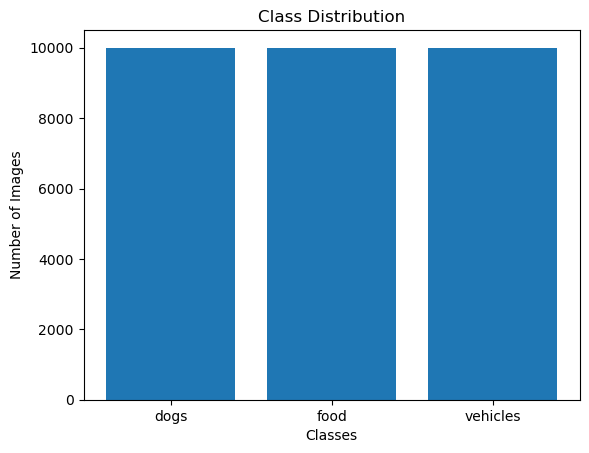

In [6]:
classes, counts = np.unique(dataset.targets, return_counts=True)
class_names = dataset.classes

plt.bar(class_names, counts)
plt.title("Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.show()

### Sample images: This graph shows a few sample images from the dataset.

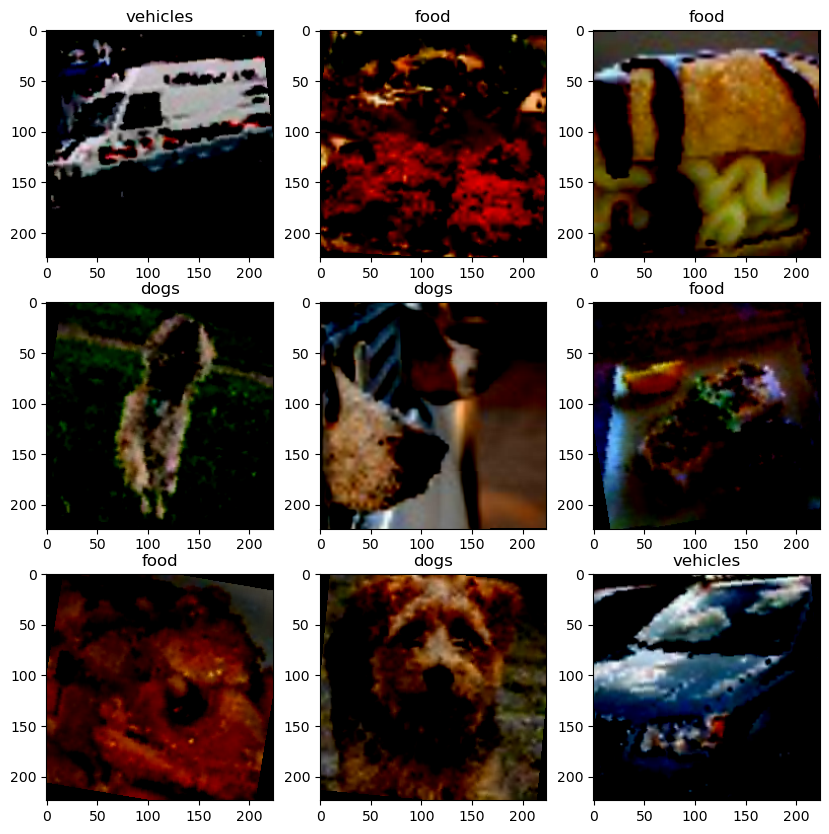

In [7]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
for i in range(3):
    for j in range(3):
        idx = random.randint(0, len(dataset))
        img, label = dataset[idx]
        axs[i,j].imshow(np.transpose(img.numpy(), (1,2,0)))
        axs[i,j].set_title(class_names[label])
plt.show()


### Random image with its label: This graph shows a single image from the dataset along with its label.

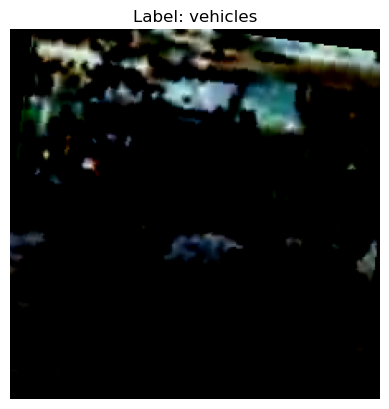

In [8]:
idx = random.randint(0, len(dataset))
img, label = dataset[idx]

plt.imshow(np.transpose(img.numpy(), (1,2,0)))
plt.title("Label: " + class_names[label])
plt.axis("off")
plt.show()

### reference
https://blog.paperspace.com/alexnet-pytorch/

### Defining Alexnet Structure

In [9]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=3):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(6400, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

### Training and Validating the model

In [10]:
def training(model,train_loader, val_loader, epochs = 20):
    print(f"run started at {str(datetime.now())}")
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
    lossFunc = nn.CrossEntropyLoss()

    list_validation_loss = []
    list_training_loss = []
    list_train_acc = []
    list_valid_acc = []
    for epoch in range(epochs):
        train_loss=0
        train_acc=0
        val_loss=0
        val_acc=0
        model.train()
        for b_id,data in enumerate(train_loader):
            features,output = data
            features,output = features.to(device),output.to(device)
            optimizer.zero_grad()
            predictions = model(features)
            loss = lossFunc(predictions, output)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(predictions.data, 1)
            train_acc += (predicted == output).float().sum().item()

        # Evaluate the model on the validation data
        model.eval()
        with torch.no_grad():
            for b_id, data in enumerate(val_loader):
                features,output = data
                features,output = features.to(device),output.to(device)
                predictions = model(features)
                loss = lossFunc(predictions, output)
                val_loss += loss.item()
                _, predicted = torch.max(predictions.data, 1)
                val_acc += (predicted == output).float().sum().item()

        epoch_train_loss = train_loss/len(train_loader)
        epoch_train_acc = train_acc/len(train_loader.dataset)
        epoch_valid_loss = val_loss/len(val_loader)
        epoch_valid_acc = val_acc/len(val_loader.dataset)
        
        list_validation_loss.append(epoch_valid_loss)
        list_training_loss.append(epoch_train_loss)
        list_train_acc.append(epoch_train_acc)
        list_valid_acc.append(epoch_valid_acc)
#         if (epoch+1)%10 ==0:
        print(f"{str(datetime.now())}")
        print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}'
          .format(epoch+1, epochs, epoch_train_loss, epoch_train_acc, epoch_valid_loss, epoch_valid_acc))

    print(f"run ended at {str(datetime.now())}")
    return list_validation_loss,list_training_loss,list_train_acc,list_valid_acc

### Testing the model on Test dataset

In [11]:
def testing(model, test_loader):
    model.eval()
    lossFunc = nn.CrossEntropyLoss()
    test_loss = 0
    test_acc = 0
    with torch.no_grad():
        for data in test_loader:
            features,output = data
            features,output = features.to(device),output.to(device)
            predictions = model(features)
            loss = lossFunc(predictions, output)
            test_loss += loss.item()
            _, predicted = torch.max(predictions.data, 1)
            test_acc += (predicted == output).float().sum().item()
    
    final_test_loss = test_loss/len(test_loader)
    final_test_acc = test_acc/len(test_loader.dataset)
    print('Test Loss: {:.4f}, Test Acc: {:.4f}'.format(final_test_loss, final_test_acc))
    return final_test_loss, final_test_acc

### Loss and Accuracy Plots function

In [12]:
def loss_acc_graphs(validation_loss,training_loss,train_acc,valid_acc):
    fig, axs = plt.subplots(1, 2, figsize=(15,5))
    axs[0].plot(validation_loss,label = "Validation Loss")
    axs[0].plot(training_loss, label = "Training Loss")
    axs[0].set_title('Loss Graph for training and validation')
    axs[0].set_xlabel('Number Of Epochs')
    axs[0].set_ylabel('Loss')
    axs[1].plot(train_acc,label = "Training Accuracy")
    axs[1].plot(valid_acc,label = "Validation Accuracy")
    axs[1].set_title('Accuracy Graph for training and validation ')
    axs[1].set_xlabel('Number Of Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[0].legend()
    axs[1].legend()
    plt.show()

### Splitting the data into training and testing and loading the data

In [13]:
# Split the dataset into 80% training data and 20% validation data
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
test_dataset = val_dataset

# Create data loaders for training and validation datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

### Calling the Alexnet function and training model

In [14]:
model = AlexNet().to(device)
validation_loss,training_loss,train_acc,valid_acc = training(model,train_loader, val_loader, epochs = 10)

run started at 2023-04-13 19:43:25.210843
2023-04-13 19:46:44.895508
Epoch [1/10], Train Loss: 0.4332, Train Acc: 0.8343, Val Loss: 0.5665, Val Acc: 0.7913
2023-04-13 19:48:50.197694
Epoch [2/10], Train Loss: 0.3187, Train Acc: 0.8843, Val Loss: 0.4448, Val Acc: 0.8473
2023-04-13 19:50:54.398155
Epoch [3/10], Train Loss: 0.2731, Train Acc: 0.8978, Val Loss: 0.2614, Val Acc: 0.9057
2023-04-13 19:52:57.986297
Epoch [4/10], Train Loss: 0.2560, Train Acc: 0.9035, Val Loss: 0.2662, Val Acc: 0.8867
2023-04-13 19:55:01.522496
Epoch [5/10], Train Loss: 0.2367, Train Acc: 0.9123, Val Loss: 0.2536, Val Acc: 0.9040
2023-04-13 19:57:04.097238
Epoch [6/10], Train Loss: 0.2121, Train Acc: 0.9226, Val Loss: 0.1791, Val Acc: 0.9338
2023-04-13 19:59:06.870059
Epoch [7/10], Train Loss: 0.1985, Train Acc: 0.9265, Val Loss: 0.1797, Val Acc: 0.9362
2023-04-13 20:01:09.129631
Epoch [8/10], Train Loss: 0.1955, Train Acc: 0.9297, Val Loss: 0.2226, Val Acc: 0.9138
2023-04-13 20:03:11.658065
Epoch [9/10], Train

### Calling the Testing function and Printing the Test loss

In [15]:
final_test_loss, final_test_acc = testing(model, test_loader)
Base_loss, Base_acc = final_test_loss, final_test_acc

Test Loss: 0.1793, Test Acc: 0.9350


### Calling the plots function

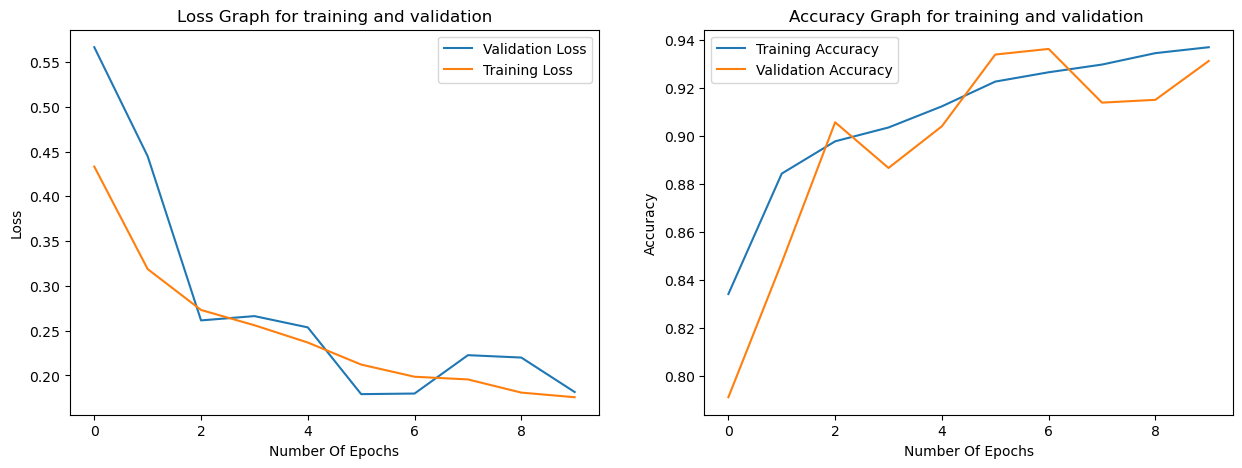

In [16]:
loss_acc_graphs(validation_loss,training_loss,train_acc,valid_acc) 

### Early stopping

In [17]:
def training_es(model, train_loader, val_loader, epochs=20, patience=5):
    print(f"run started at {str(datetime.now())}")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    lossFunc = nn.CrossEntropyLoss()

    list_validation_loss = []
    list_training_loss = []
    list_train_acc = []
    list_valid_acc = []
    best_valid_loss = float('inf')
    best_model = None
    early_stop_counter = 0
    
    for epoch in range(epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        model.train()
        
        for b_id, data in enumerate(train_loader):
            features, output = data
            features, output = features.to(device), output.to(device)
            optimizer.zero_grad()
            predictions = model(features)
            loss = lossFunc(predictions, output)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(predictions.data, 1)
            train_acc += (predicted == output).float().sum().item()

        # Evaluate the model on the validation data
        model.eval()
        with torch.no_grad():
            for b_id, data in enumerate(val_loader):
                features, output = data
                features, output = features.to(device), output.to(device)
                predictions = model(features)
                loss = lossFunc(predictions, output)
                val_loss += loss.item()
                _, predicted = torch.max(predictions.data, 1)
                val_acc += (predicted == output).float().sum().item()

        epoch_train_loss = train_loss/len(train_loader)
        epoch_train_acc = train_acc/len(train_loader.dataset)
        epoch_valid_loss = val_loss/len(val_loader)
        epoch_valid_acc = val_acc/len(val_loader.dataset)
        
        list_validation_loss.append(epoch_valid_loss)
        list_training_loss.append(epoch_train_loss)
        list_train_acc.append(epoch_train_acc)
        list_valid_acc.append(epoch_valid_acc)
        print(f"{str(datetime.now())} ")
        print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}'
              .format(epoch+1, epochs, epoch_train_loss, epoch_train_acc, epoch_valid_loss, epoch_valid_acc))
        
        if epoch_valid_loss < best_valid_loss:
            early_stop_counter = 0
            best_valid_loss = epoch_valid_loss
            best_model = model.state_dict()
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print('Validation loss did not improve for {} epochs, stopping training'.format(patience))
                break
    
    print(f"run ended at {str(datetime.now())}")
    
    # Load the best model
    if best_model:
        model.load_state_dict(best_model)
    
    return list_validation_loss, list_training_loss, list_train_acc, list_valid_acc


In [18]:
# training_es(model, train_loader, val_loader)
validation_loss,training_loss,train_acc,valid_acc = training_es(model, train_loader, val_loader, epochs=10)

run started at 2023-04-13 20:05:35.742798
2023-04-13 20:07:37.152766 
Epoch [1/10], Train Loss: 0.1703, Train Acc: 0.9393, Val Loss: 0.1558, Val Acc: 0.9423
2023-04-13 20:09:39.119457 
Epoch [2/10], Train Loss: 0.1605, Train Acc: 0.9410, Val Loss: 0.1547, Val Acc: 0.9402
2023-04-13 20:11:41.389696 
Epoch [3/10], Train Loss: 0.1544, Train Acc: 0.9437, Val Loss: 0.1895, Val Acc: 0.9305
2023-04-13 20:13:44.076299 
Epoch [4/10], Train Loss: 0.1468, Train Acc: 0.9465, Val Loss: 0.1671, Val Acc: 0.9335
2023-04-13 20:15:46.676418 
Epoch [5/10], Train Loss: 0.1362, Train Acc: 0.9497, Val Loss: 0.1801, Val Acc: 0.9390
2023-04-13 20:17:48.709430 
Epoch [6/10], Train Loss: 0.1325, Train Acc: 0.9514, Val Loss: 0.1488, Val Acc: 0.9450
2023-04-13 20:19:50.329181 
Epoch [7/10], Train Loss: 0.1271, Train Acc: 0.9534, Val Loss: 0.1390, Val Acc: 0.9535
2023-04-13 20:21:51.338687 
Epoch [8/10], Train Loss: 0.1204, Train Acc: 0.9555, Val Loss: 0.1518, Val Acc: 0.9433
2023-04-13 20:23:52.802509 
Epoch [9/1

In [19]:
final_test_loss, final_test_acc = testing(model, test_loader)
early_stopping_acc = final_test_acc

Test Loss: 0.1467, Test Acc: 0.9470


### Calling the plots function

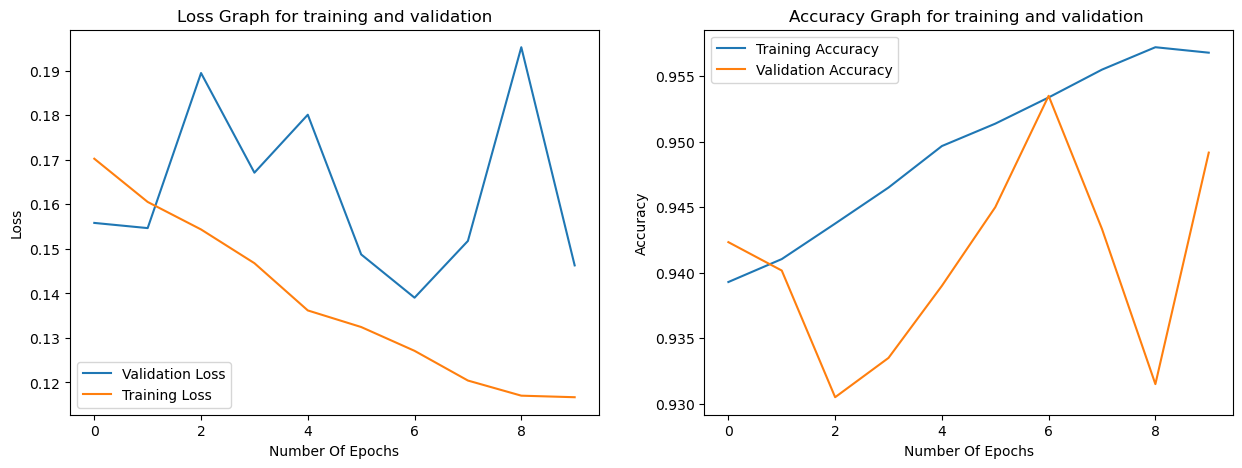

In [20]:
loss_acc_graphs(validation_loss,training_loss,train_acc,valid_acc)

## Part 4

### Defining the Alexnet structure for SVHN dataset

In [21]:
class SVHN_AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(SVHN_AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(6400, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

### Reading and loading the SVHN dataset

In [47]:
svhn_transform = transforms.Compose([ transforms.Resize(255),
                transforms.CenterCrop(224),transforms.ToTensor()])
svhn_dataset=torchvision.datasets.SVHN(root='./data', download=True, transform=svhn_transform)
len(svhn_dataset)

Using downloaded and verified file: ./data/train_32x32.mat


73257

In [23]:
print("Number of entries (images) in SVHN dataset: ", len(svhn_dataset))
print("Number of variables in SVHN dataset: ", len(svhn_dataset[0]))

Number of entries (images) in SVHN dataset:  73257
Number of variables in SVHN dataset:  2


### Bar chart of class distribution: This graph shows the number of images in each class

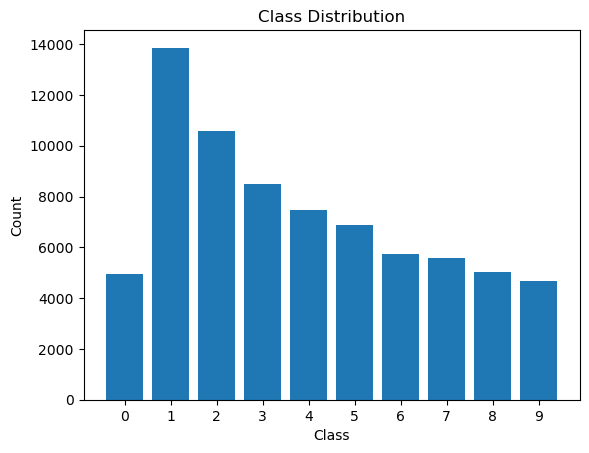

In [55]:
classes, counts = np.unique(svhn_dataset.labels, return_counts=True)
class_names = [str(i) for i in range(10)]

# Create the bar plot
plt.bar(class_names, counts)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

### Sample images: This graph shows a few sample images from the dataset.

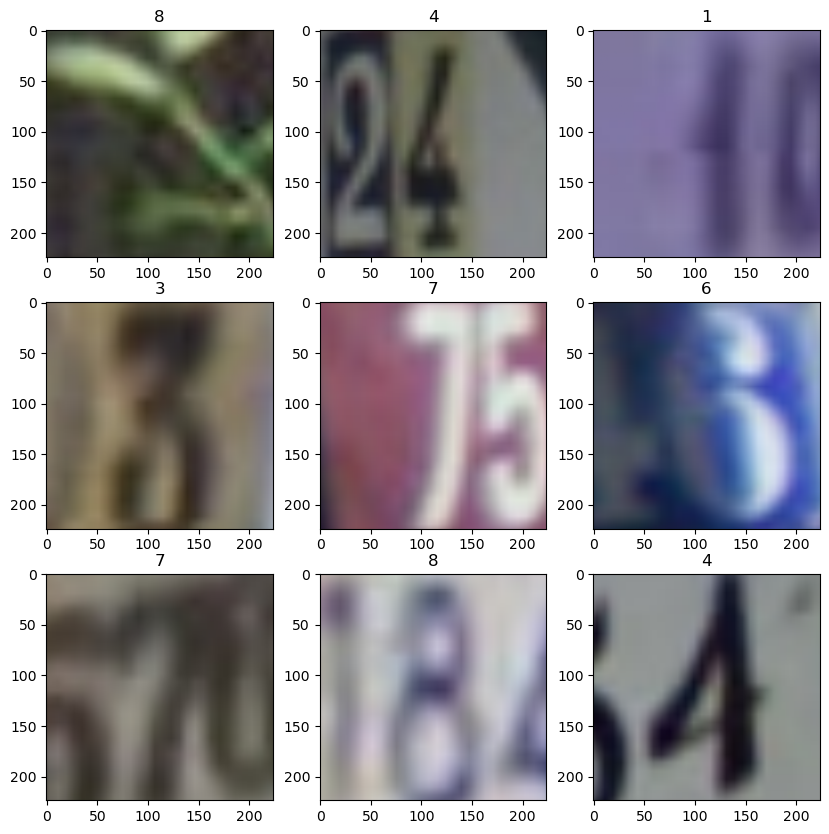

In [56]:
class_names = [str(i) for i in range(10)]

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
for i in range(3):
    for j in range(3):
        idx = random.randint(0, len(svhn_dataset))
        img, label = svhn_dataset[idx]
        axs[i,j].imshow(np.transpose(img.numpy(), (1,2,0)))
        axs[i,j].set_title(class_names[label])
plt.show()


### Random image with its label: This graph shows a single image from the dataset along with its label.

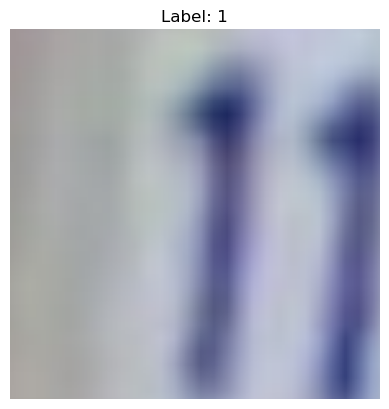

In [57]:
idx = random.randint(0, len(svhn_dataset)-1)
img, label = svhn_dataset[idx]

plt.imshow(np.transpose(img, (1, 2, 0)))
plt.title("Label: " + str(label))
plt.axis("off")
plt.show()

### reading the train data

In [24]:
svhn_train_data=torchvision.datasets.SVHN(root='./data',split='train', download=True, transform=svhn_transform)
len(svhn_train_data)

Using downloaded and verified file: ./data/train_32x32.mat


73257

### reading the test data

In [25]:
svhn_test_data = torchvision.datasets.SVHN(root='./data',split='test', download=True, transform=svhn_transform)
len(svhn_test_data)

  0%|          | 0/64275384 [00:00<?, ?it/s]

26032

### Data Augmentation
### Case 1

In [26]:
aug_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [27]:
aug_train_data=torchvision.datasets.SVHN(root='./data',split='train', download=True, transform=aug_transform)
len(aug_train_data)

Using downloaded and verified file: ./data/train_32x32.mat


73257

### Cocatenating original dataset with augmented daatset for case1

In [28]:
dataset_aug=torch.utils.data.ConcatDataset([svhn_train_data,aug_train_data])

### Visualizations

### Bar chart of class distribution: This graph shows the number of images in each class

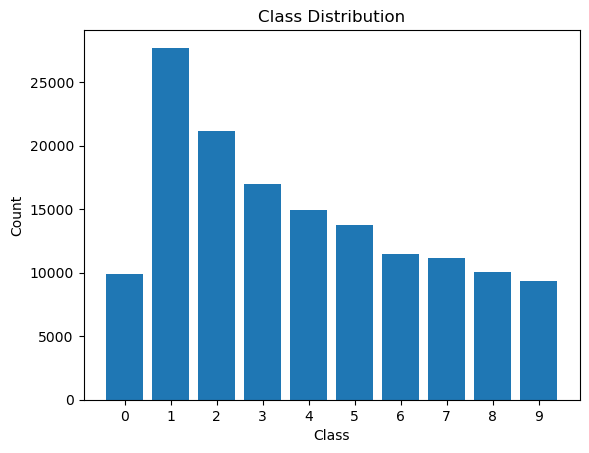

In [29]:
targets = torch.cat([torch.from_numpy(dataset.labels) for dataset in dataset_aug.datasets])
classes, counts = torch.unique(targets, return_counts=True)
class_names = [str(i) for i in range(10)]

plt.bar(class_names, counts)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


### Sample images: This graph shows a few sample images from the dataset.

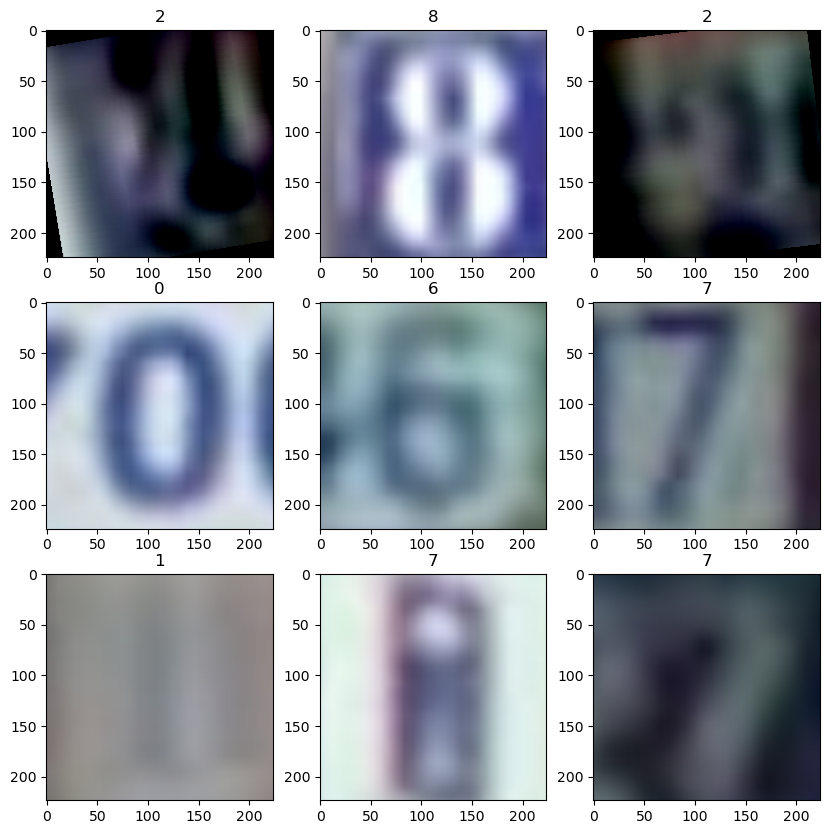

In [30]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
for i in range(3):
    for j in range(3):
        idx = random.randint(0, len(dataset_aug))
        img, label = dataset_aug[idx]
        axs[i,j].imshow(np.transpose(img.numpy(), (1,2,0)))
        axs[i,j].set_title(class_names[label])
plt.show()


### Random image with its label: This graph shows a single image from the dataset along with its label.

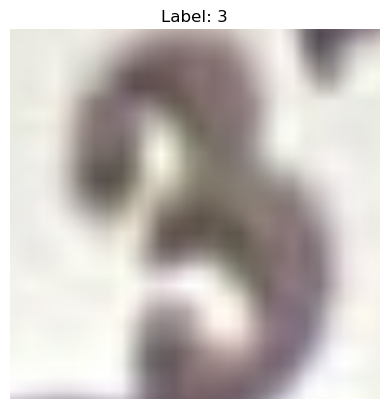

In [31]:
idx = random.randint(0, len(svhn_dataset))
img, label = svhn_dataset[idx]

plt.imshow(np.transpose(img.numpy(), (1,2,0)))
plt.title("Label: " + class_names[label])
plt.axis("off")
plt.show()

### splitting the data inti train and test

In [32]:
svhn_train_size = int(0.8 * len(dataset_aug))
svhn_val_size = len(dataset_aug) - svhn_train_size
svhn_train_dataset, svhn_val_dataset = random_split(dataset_aug, [svhn_train_size, svhn_val_size])
svhn_test_dataset = svhn_val_dataset

# Create data loaders for training and validation datasets
svhn_train_loader = torch.utils.data.DataLoader(svhn_train_dataset, batch_size=32, shuffle=True)
svhn_val_loader = torch.utils.data.DataLoader(svhn_val_dataset, batch_size=32, shuffle=False)
svhn_test_loader = torch.utils.data.DataLoader(svhn_test_dataset, batch_size=32, shuffle=False)

In [33]:
svhn_model = SVHN_AlexNet().to(device)
validation_loss,training_loss,train_acc,valid_acc = training(svhn_model,svhn_train_loader, svhn_val_loader, epochs = 5)

run started at 2023-04-13 20:26:27.776679
2023-04-13 20:33:32.368690
Epoch [1/5], Train Loss: 1.0642, Train Acc: 0.6367, Val Loss: 0.5320, Val Acc: 0.8369
2023-04-13 20:40:35.432092
Epoch [2/5], Train Loss: 0.4384, Train Acc: 0.8641, Val Loss: 0.3565, Val Acc: 0.8910
2023-04-13 20:47:38.515042
Epoch [3/5], Train Loss: 0.3526, Train Acc: 0.8929, Val Loss: 0.2888, Val Acc: 0.9133
2023-04-13 20:54:42.431107
Epoch [4/5], Train Loss: 0.3076, Train Acc: 0.9080, Val Loss: 0.2744, Val Acc: 0.9195
2023-04-13 21:01:47.018129
Epoch [5/5], Train Loss: 0.2775, Train Acc: 0.9176, Val Loss: 0.2504, Val Acc: 0.9261
run ended at 2023-04-13 21:01:47.018286


In [34]:
final_test_loss, final_test_acc = testing(svhn_model, svhn_test_loader)
Base_loss, Base_acc = final_test_loss, final_test_acc

Test Loss: 0.2492, Test Acc: 0.9262


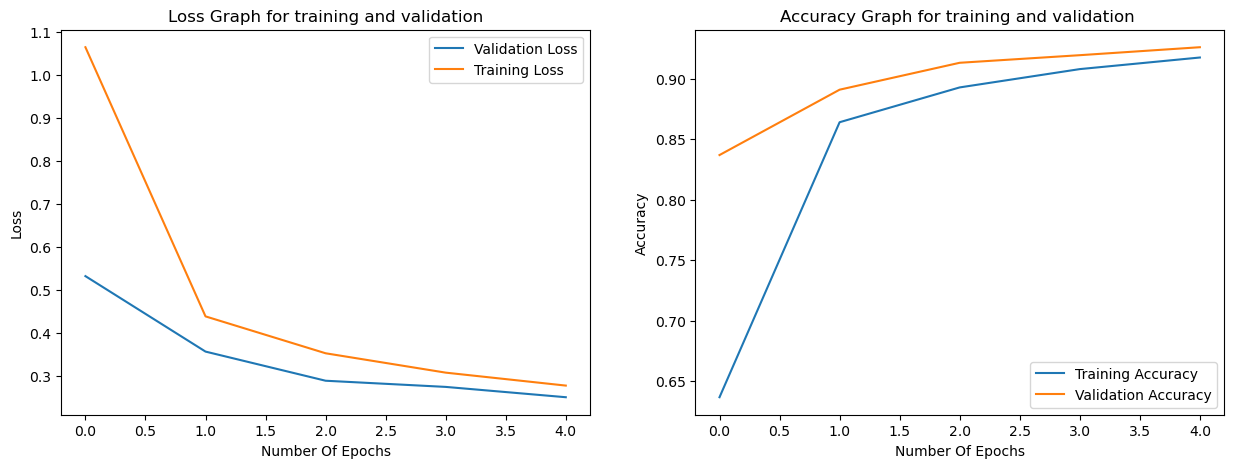

In [35]:
loss_acc_graphs(validation_loss,training_loss,train_acc,valid_acc)

### Data Augmentation
### Case 2

In [36]:
aug_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [37]:
aug_train_data=torchvision.datasets.SVHN(root='./data',split='train', download=True, transform=aug_transform)
len(aug_train_data)

Using downloaded and verified file: ./data/train_32x32.mat


73257

### Cocatenating original dataset with augmented daatset for case 2

In [38]:
dataset_aug=torch.utils.data.ConcatDataset([svhn_train_data,aug_train_data])

### Visualizations

### Bar chart of class distribution: This graph shows the number of images in each class

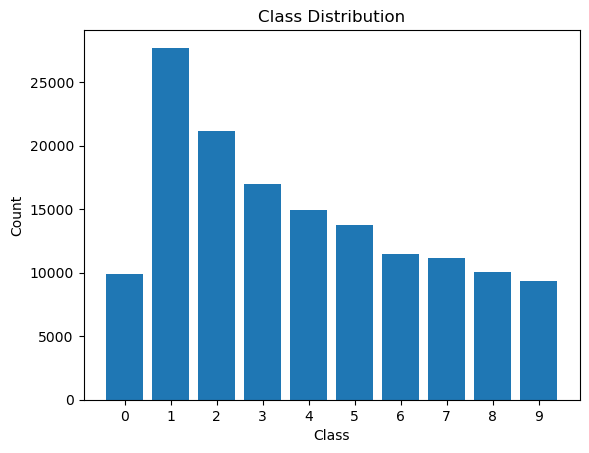

In [39]:
targets = torch.cat([torch.from_numpy(dataset.labels) for dataset in dataset_aug.datasets])
classes, counts = torch.unique(targets, return_counts=True)
class_names = [str(i) for i in range(10)]

plt.bar(class_names, counts)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


### Sample images: This graph shows a few sample images from the dataset.

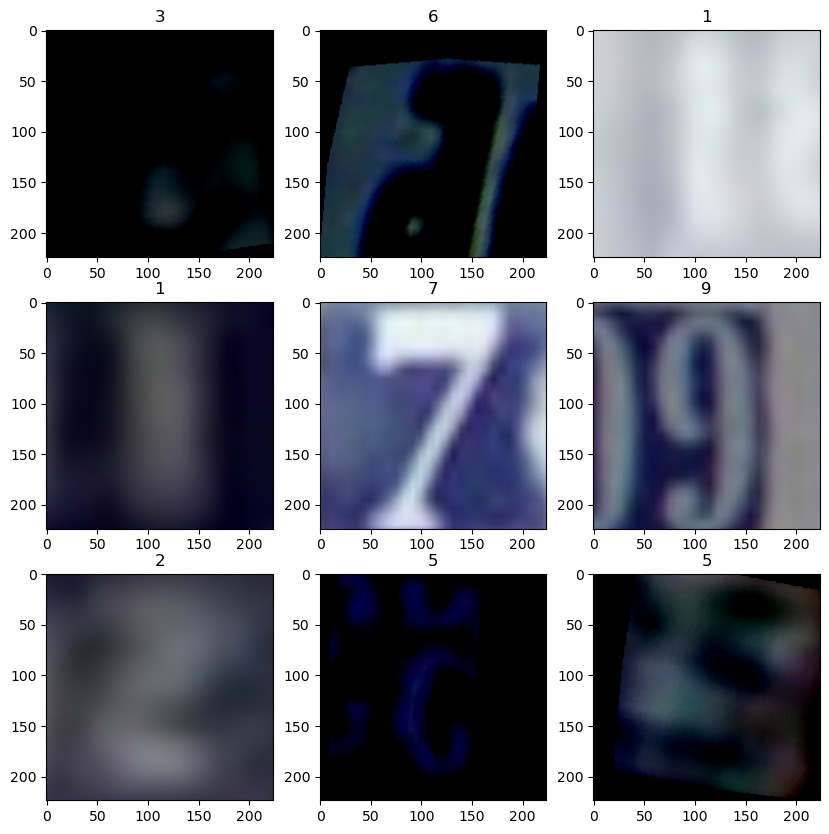

In [40]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
for i in range(3):
    for j in range(3):
        idx = random.randint(0, len(dataset_aug))
        img, label = dataset_aug[idx]
        axs[i,j].imshow(np.transpose(img.numpy(), (1,2,0)))
        axs[i,j].set_title(class_names[label])
plt.show()


### Random image with its label: This graph shows a single image from the dataset along with its label.

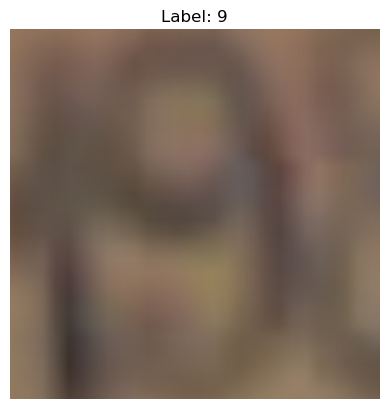

In [41]:
idx = random.randint(0, len(svhn_dataset))
img, label = svhn_dataset[idx]

plt.imshow(np.transpose(img.numpy(), (1,2,0)))
plt.title("Label: " + class_names[label])
plt.axis("off")
plt.show()

In [42]:
svhn_train_size = int(0.8 * len(dataset_aug))
svhn_val_size = len(dataset_aug) - svhn_train_size
svhn_train_dataset, svhn_val_dataset = random_split(dataset_aug, [svhn_train_size, svhn_val_size])
svhn_test_dataset = svhn_val_dataset

# Create data loaders for training and validation datasets
svhn_train_loader = torch.utils.data.DataLoader(svhn_train_dataset, batch_size=32, shuffle=True)
svhn_val_loader = torch.utils.data.DataLoader(svhn_val_dataset, batch_size=32, shuffle=False)
svhn_test_loader = torch.utils.data.DataLoader(svhn_test_dataset, batch_size=32, shuffle=False)

In [43]:
len(svhn_train_loader)

3663

In [44]:
svhn_model = SVHN_AlexNet().to(device)
validation_loss,training_loss,train_acc,valid_acc = training(svhn_model,svhn_train_loader, svhn_val_loader, epochs = 5)

run started at 2023-04-13 21:02:54.889350
2023-04-13 21:17:38.090998
Epoch [1/5], Train Loss: 1.0376, Train Acc: 0.6480, Val Loss: 0.5036, Val Acc: 0.8410
2023-04-13 21:32:17.866497
Epoch [2/5], Train Loss: 0.4810, Train Acc: 0.8491, Val Loss: 0.3914, Val Acc: 0.8828
2023-04-13 21:46:53.218070
Epoch [3/5], Train Loss: 0.3957, Train Acc: 0.8786, Val Loss: 0.3352, Val Acc: 0.8990
2023-04-13 22:01:27.624936
Epoch [4/5], Train Loss: 0.3476, Train Acc: 0.8941, Val Loss: 0.3138, Val Acc: 0.9078
2023-04-13 22:16:04.262070
Epoch [5/5], Train Loss: 0.3177, Train Acc: 0.9039, Val Loss: 0.2879, Val Acc: 0.9148
run ended at 2023-04-13 22:16:04.262244


In [45]:
final_test_loss, final_test_acc = testing(svhn_model, svhn_test_loader)
Base_loss, Base_acc = final_test_loss, final_test_acc

Test Loss: 0.2920, Test Acc: 0.9136


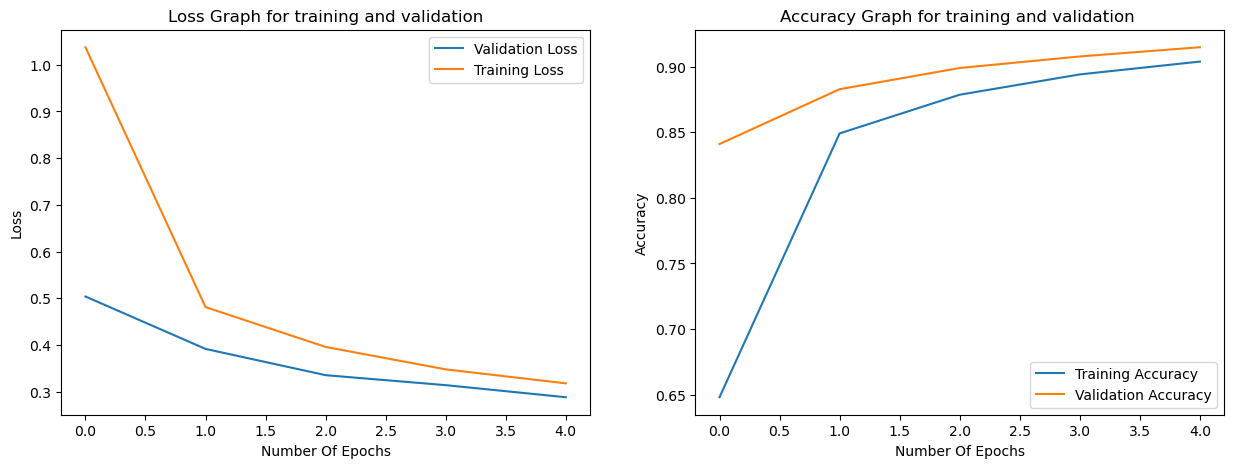

In [46]:
loss_acc_graphs(validation_loss,training_loss,train_acc,valid_acc)

### References

https://medium.com/prathmesh-bhansali/exploring-svhn-using-deep-neural-network-1213959db92c

https://gist.github.com/ApprenticeZ/fa8f411add1240d3021b4547cf4a8b8a

https://pytorch.org/vision/stable/transforms.html

https://www.programcreek.com/python/example/105105/torchvision.datasets.SVHN